# MNIST Fashion Dataset Dimensionality Reduction
Performing dimensionality reduction for visualization, effectiveness of compression, and hyperparameter tuning using cross-validation

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
import pylab as py
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


## Import the Fasion MNIST dataset
And store class names under class_names

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

## Preprocess Data
First we need to normalize and flatten the dataset in order to perform PCA on it

In [3]:
x_train_shape = x_train.shape
x_test_shape = x_test.shape

#these are the actual images (28, 28) in shape
scaler = 255.0 
x_train_scaled = x_train / scaler
x_test_scaled = x_test / scaler

# flattened images - each row is an image, each column is a pixel (or feature)
# 28 * 28 = 784
x_train_scaled_flat = x_train_scaled.reshape(x_train_shape[0], 784)
x_test_scaled_flat = x_test_scaled.reshape(x_test_shape[0], 784)

## Dimensionality reduction for Visualization
Using Pricipal Component Analysis, we can reduce the dimensionality of the 28x28 pixel data from the MNSIST Fashion Dataset to something that we can vizualize on a 2-dimensional scatterplot

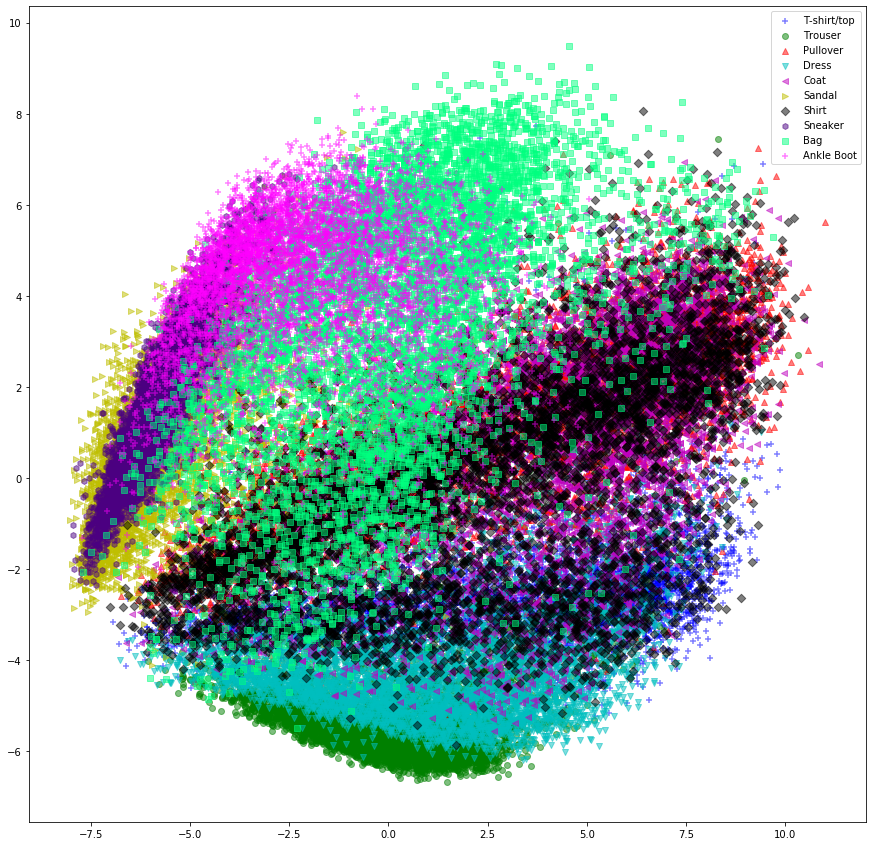

In [4]:
from sklearn.decomposition import PCA
from itertools import cycle

pca = PCA(n_components=3)
x_train_pca = pca.fit_transform(x_train_scaled_flat)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'indigo', 'springgreen','fuchsia']
markers = ['+', 'o', '^', 'v', '<', '>', 'D', 'h', 's']
py.figure(figsize=(15,15))

for i, c, m in zip(np.unique(y_train), cycle(colors), cycle(markers)):
    py.scatter(x_train_pca[y_train == i, 0], x_train_pca[y_train == i, 1], 
               c=c, marker=m, label=i, alpha=0.5)

_ = py.legend(loc='best')
_ = py.legend(class_names)

With only 2 PCA components there is quite a bit of overlap in our scatterplot such as:
- Sandals and Sneakers 
- Ankle Boots and Sneakers
- Bags, Shirts, Coats and T-Shirt/Tops

## Unsupervised Learning for Compression
One of the benifits of a reduced dimensionality is the ability to compress a signal. Lets see how far how far we can use PCA to compress the original 28x28 dataset while still maintaining distinction between different articles of clothing.

In [5]:
def plot_gallery(data, labels, shape, interpolation='nearest'):
    for i in range(data.shape[0]):
        py.subplot(1, data.shape[0], (i + 1))
        py.imshow(data[i].reshape(shape), interpolation=interpolation)
        py.title(class_names[labels[i]])
        py.xticks(()), py.yticks(())
        py.gray()

Compressed images of 10 items
with this many PCA components: [1, 2, 10, 20, 40, 64, 128, 784]


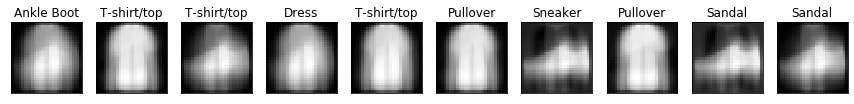

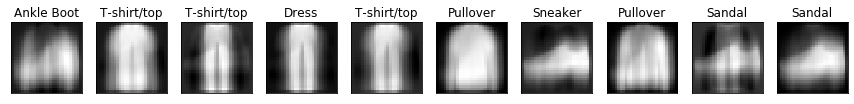

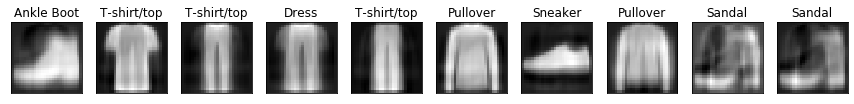

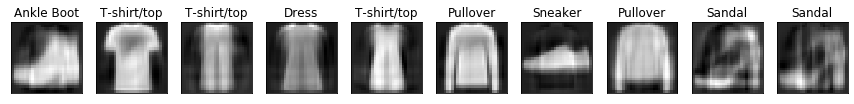

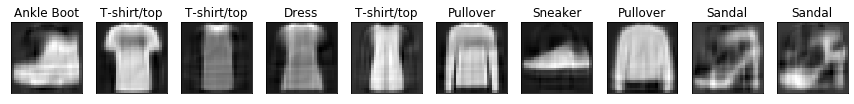

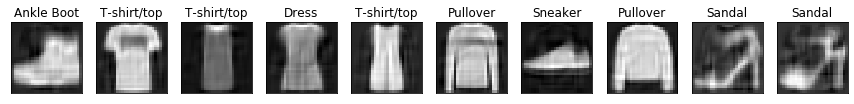

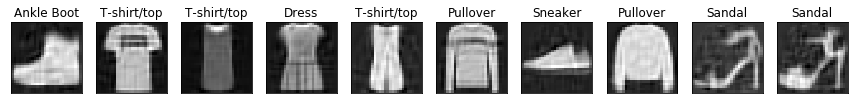

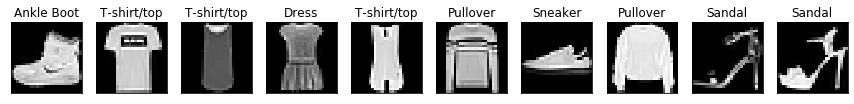

In [6]:
n = 10
dims = [1,2,10,20,40,64,128,784]
print('Compressed images of',n,'items')
print('with this many PCA components:',dims)
for d in dims:  # dimensionality for compressed signal
    pca = PCA(n_components=d)
    pca.fit_transform(x_train_scaled_flat)
    reduced_X = pca.transform(x_train_scaled_flat[0:n]) # the reduced dimensionality
    recovered_X = pca.inverse_transform(reduced_X)
    py.figure(figsize=(15,15))
    plot_gallery(recovered_X, y_train[0:n], shape=(28, 28))

Obviously the clearest image is the uncompressed one at with 784 dimensions. Down to 128 dimensions, there is a difference but it is still very slight. This trend continues all the way down to a mere 64 Dimensions. It is after this point we start seeing clear blurring of lines between articlees of clothing, until the model outright fails at 20 dimensions, mistaking a top(3rd item) for a pair of pants. This only gets worse as the dimensions decrease. However certain articles of clothing are still identifiable, such as the sneaker(7th item) and the pullover(8th item).

## Unsupervised learning to improve future classification
We will first train a Gaussian Naive Bayes model directly on the pixels

In [7]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB().fit(x_train_scaled_flat, y_train)
train_score = model.score(x_train_scaled_flat, y_train) 
print('Training Score:',train_score)

test_score = model.score(x_test_scaled_flat, y_test)
print('Test Score:',test_score)

Training Score: 0.5877833333333333
Test Score: 0.5856


Now lets use PCA features, earlier we noticed that 64 dimensions seems to be a sweet spot so let's try that

In [8]:
pca = PCA(n_components=64)
pca.fit(x_train_scaled_flat)

tX_train = pca.transform(x_train_scaled_flat)
tX_test = pca.transform(x_test_scaled_flat)

model = GaussianNB().fit(tX_train, y_train)
train_score = model.score(tX_train, y_train) 
print('Training Score:',train_score)

test_score = model.score(tX_test, y_test)
print('Test Score:',test_score)

from sklearn import metrics
y_test_pred = model.predict(tX_test)
expected = y_test
predicted = model.predict(tX_test)
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Training Score: 0.7801333333333333
Test Score: 0.7672
Confusion matrix:
[[763   0  23  67   6   3  83   0  55   0]
 [  9 890  22  52   5   1  12   0   9   0]
 [ 15   0 617   8 131   2 186   0  41   0]
 [ 59   3  12 799  29   1  75   0  22   0]
 [  4   0 127  36 656   0 153   0  24   0]
 [  1   0   0   3   0 780  14 146  34  22]
 [184   0 125  39  79   3 504   0  66   0]
 [  2   0   0   0   0  39   1 882   1  75]
 [  9   0  16   7   6  14  41  25 880   2]
 [  0   0   0   0   0  25   5  54  15 901]]


There is a clear improvement in accuracy, so let see how using a different number of components as our features can affect accuracy.

Text(0, 0.5, 'digit recognition accuracy')

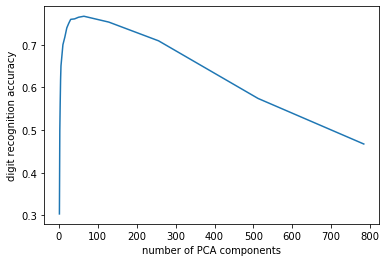

In [9]:
accuracy = []
n_comp = [1,2,3,4,5,10,15,20,25,30,40,50,64,128,256,512,784]
for i in n_comp:
    pca = PCA(n_components=i)
    pca.fit(x_train_scaled_flat)

    tX_train = pca.transform(x_train_scaled_flat)
    tX_test = pca.transform(x_test_scaled_flat)

    model = GaussianNB().fit(tX_train, y_train)
    test_score = model.score(tX_test, y_test)
    accuracy.append(test_score)

py.plot(n_comp, accuracy)
py.xlabel('number of PCA components')
py.ylabel('digit recognition accuracy')

Interesting! So as we increase the number of dimensions, there seems to be some overfitting and accuracy on the test set goes down! Lets see if we can finetune this and find out an optimal number of components.

Text(0, 0.5, 'digit recognition accuracy')

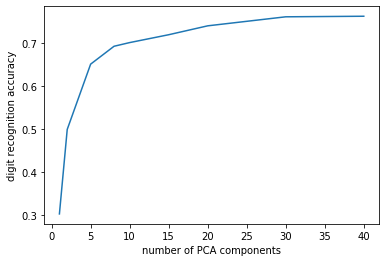

In [10]:
accuracy = []
n_comp = [1,2,5,8,10,15,20,30,40]
for i in n_comp:
    pca = PCA(n_components=i)
    pca.fit(x_train_scaled_flat)

    tX_train = pca.transform(x_train_scaled_flat)
    tX_test = pca.transform(x_test_scaled_flat)

    model = GaussianNB().fit(tX_train, y_train)
    test_score = model.score(tX_test, y_test)
    accuracy.append(test_score)

py.plot(n_comp, accuracy)
py.xlabel('number of PCA components')
py.ylabel('digit recognition accuracy')

10 components seems like a good option with relatively high accuracy but low dimensions.

In [11]:
pca = PCA(n_components=10)
pca.fit(x_train_scaled_flat)
x_train_scaled_flat_compressed = pca.transform(x_train_scaled_flat)
x_test_scaled_flat_compressed = pca.transform(x_test_scaled_flat)

model = GaussianNB().fit(x_train_scaled_flat_compressed, y_train)
test_score = model.score(x_test_scaled_flat_compressed, y_test)
print('Test Score:',test_score)

Test Score: 0.7003


## Hyperparameter Tuning with cross-validation
Now lets try out a few other models and tune their hyperparameters with cross-validation and a hold-out test set

In [12]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV,cross_val_score
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

final = [[""]*4 for i in range(3)]

n_samples = len(x_train)
expected = y_train

### K-Nearest Neighbour

In [13]:
from sklearn.neighbors import KNeighborsClassifier
parameters={'n_neighbors':list(range(1,10))}
knn = KNeighborsClassifier()
scores = cross_val_score(knn, x_train_scaled_flat_compressed, y_train, cv=5)
default_train=np.mean(scores)

clf=GridSearchCV(knn, parameters, cv=5,scoring="accuracy",iid=False)
clf.fit(x_train_scaled_flat_compressed,y_train)
best_train=clf.best_score_
nn=clf.best_estimator_.n_neighbors

y_pred = clf.predict(x_test_scaled_flat_compressed) # runs the model with the best score
best_test=metrics.accuracy_score(y_test,y_pred)

final[0][0]=str(default_train)
final[0][1]=str(best_train)
final[0][2]="n_neighbors: "+str(nn)
final[0][3]=str(best_test)

### Decision Trees

In [14]:
from sklearn import tree
DT=tree.DecisionTreeClassifier()
scores=cross_val_score(DT, x_train_scaled_flat_compressed, y_train, cv=5)
default_train=np.mean(scores)

parameters={'min_samples_split':list(range(2,10))}
clf=GridSearchCV(DT, parameters, cv=5,scoring="accuracy",iid=False)
clf.fit(x_train_scaled_flat_compressed,y_train)
best_train=clf.best_score_
min_samples=clf.best_estimator_.min_samples_split

y_pred = clf.predict(x_test_scaled_flat_compressed) # runs the model with the best score
best_test=metrics.accuracy_score(y_test,y_pred)

final[1][0]=str(default_train)
final[1][1]=str(best_train)
final[1][2]="min_samples: "+str(min_samples)
final[1][3]=str(best_test)

### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
regression=LogisticRegression(penalty='l1', solver='saga', tol=0.01)
scores=cross_val_score(regression, x_train_scaled_flat_compressed, y_train, cv=5)
default_train=np.mean(scores)

parameters={'C':[10**(i-4) for i in range(9)]}
clf=GridSearchCV(regression, parameters, cv=5,scoring="accuracy",iid=False)
clf.fit(x_train_scaled_flat_compressed,y_train)
best_train=clf.best_score_
C=clf.best_estimator_.C

y_pred = clf.predict(x_test_scaled_flat_compressed) # runs the model with the best score
best_test=metrics.accuracy_score(y_test,y_pred)

final[2][0]=str(default_train)
final[2][1]=str(best_train)
final[2][2]="C: "+str(C)
final[2][3]=str(best_test)

In [16]:
left=["K-nearest neighbors: ","Decision Trees:      ","Logistic Regression: "]
print("Model                "," Default Accuracy","Tuned Valid. Acc.",
 " Hyperparameters ","  Test Set Acc. ",sep="|",end="|\n")
for i in range(50):
 print("_",end="_")
print("")
for i in range(3):
 print(left[i],end="|")
 for j in range(4):
   print('{:>17.15}'.format(final[i][j]),end="|")
 print("")

Model                | Default Accuracy|Tuned Valid. Acc.| Hyperparameters |  Test Set Acc. |
____________________________________________________________________________________________________
K-nearest neighbors: |  0.8140333333333|  0.8182333333333|   n_neighbors: 9|           0.8138|
Decision Trees:      |  0.7442833333333|  0.7484666666666|   min_samples: 9|           0.7494|
Logistic Regression: |  0.7650666666666|  0.7652166666666|           C: 100|            0.755|


So our accuracy when using Gaussian Naive Bayes on the entire Pixel Data was 0.586. By using PCA for feature selection and dimensionality reduction, using only 10 dimensions we were able to achieve an accuracy improvement up to 0.7. Finally, we were able to gain higher accuracy by using  other models, especially K-nearest neighbors, with an accuracy of 0.8138. However using Grid Search and Cross Validation for Hyperparameter tuning did not increase our accuracy on each model by any significant amount.

## Conclusion
So to wrap up we have:
- Applied Principal Component Analysis to the MNIST Fashion Dataset, reducing it to 2 dimensions
    - Built a scatter plot to visualize the 2 dimensional data
    - Observed overlap among different articles of clothing such as shirts and pull overs
- Observed how varying degrees of Dimensionality Reduction affect image compression
    - Noting how it is possible to compress images by a factor of 6 and still maintain high levels of fidelity
- Trained a Gaussian Naive Bayes model on the uncompressed data
    - Improved the accuracy of the model through dimensionality reduction
- Used our compressed data to train multiple other models
    - Tune Hyperparameters using GridSearch and CrossValidation
    
Through some hyperparameter tuning and compression we were able to achieve quite a high amount of accuracy on our final K-Nearest Neighbors model at 0.8138. However you may note that in compared to a fairly easy to implement deep learning model employed in the notebook [Keras-Learning-Curve](https://github.com/Jaw-Ahm/Keras-Learning-Curve), we were able to achieve a higher accuracy of 0.876 without much tuning at all.